# Create CI/CD Automation Using - Git source example


This example shows how to create a project in MLRun for CI/CD Automation based on a remote source e.g git - this process is equivalent for using tar.gz, zip archive files.

After this example you will learn how to:
* Create a new MLRun project
* Set a project remote or archive source
* Run and set MLRun functions using git source code
* Run and set MLRun workflow
* Set and register MLRun artifacts
* Create and save project YAML 
* Push and Manage your git repo or archive file

Install mlrun - if mlrun does not installed use ``pip install mlrun==<mlrun server version>`` or ``sh align_mlrun.sh`` (our default mlrun installer - automatically install the server version)

In [1]:
import mlrun

MLRun provides you three option to create or loading a project:

1. [get_or_create_project](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=get_or_create_project#mlrun.projects.get_or_create_project) - this method allows you to load a project from MLRun DB or optionally load it from a yaml/zip/tar/git template, and create a new project if doesnt exist
2. [new_project](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=new_project#mlrun.projects.new_project) - Create a new MLRun project, optionally load it from a yaml/zip/tar/git template.
3. [load_project](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=load_project#mlrun.projects.load_project) - Load an MLRun project from yaml/zip/tar/git/dir or from MLRun db


**Note -** for loading a project you must have a project.yaml file that may include all the relevant metadata such as funciton, workflows and artifacts in your repo/archive file or to have the project stored in MLRun DB.

### Creating a project

This example demostrate how to create a project for CI/CD when:
1. you need to test you code in local mode - clone the files before running this notebook
2. you have python code files that are ready to run in your remote or archive source
3. you do not have project yaml file in your remote or archive source - a new project is created 

In [2]:
#creating a new project or load it from DB
project = mlrun.get_or_create_project(name='new-git-proj',context='./',init_git=True)

> 2023-04-09 09:06:27,672 [info] Created and saved project new-git-proj: {'from_template': None, 'overwrite': False, 'context': './', 'save': True}
> 2023-04-09 09:06:27,674 [info] created project new-git-proj and saved in MLRun DB


**name -** project name

**context -** project local directory path (default value = "./")

**init git -** if True, will git init the context dir

When you create a new project MLRun create a light project YAML, for example: 
````
kind: project
metadata:
  name: new-git-proj
  created: '2022-06-30T09:41:05.612000'
spec:
  functions: []
  workflows: []
  artifacts: []
  desired_state: online
status:
  state: online
````
For update project YAML use **projec.save()**

### Set a project remote or archive source

To point the project to a specific source you need to set a project source using [project.set_source](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=set_source#mlrun.projects.MlrunProject.set_source) method in addition you can set the pull_at_runtime (e.g load_source_on_run) flag value and the project working dir.

This method will add the source,pull_at_runtime and the project working dir to the project.yaml and will copy to the functions spec when setting with_repo=True in the set_function method (will explain better in details).

**Note -** Please add git branch or refs to the source e.g.: 'git://<url>/org/repo.git#<branch-name or refs/heads/..>'

In [3]:
source = 'git://github.com/GiladShapira94/example-ci-cd.git#master'

In [4]:
project.set_source(source=source,pull_at_runtime=True)

**pull_at_runtime -** flag will determine if the code is loaded in runtime to the k8s pod or added to the image during build or function deployment. the first (at runtime) option is better for debugging while the secound is better for production. Note that if you choose the 2nd option you'll need to build the function before run.

### Run and set MLRun functions using git source code

For the first time you are working with a remote or an archive source code e.g git or zip file with MLRun, the first thing you want to do is to clone or extract your files to the project context to start developing and run your function in MLRun (for running function in local your files must be stored in the project context folder e.g ./project-context or set the absulte file path).

If you have files that are allready competibile to run with MLRun in remote you do not need to clone or extarct the files.

#### Set MLRun functions to the project

For functions definations use the [project.set_function](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=set_function#mlrun.projects.MlrunProject.set_function) method.

The **set_function** method allow you to set the functions attributes in the project YAML, for example: 
function source (YAML, py, ipynb, function object) , name of the fucntion, function handler, function image,function kind and function requirmnets.

**Note -** Most of the time we will store the code source file under a folder named src in the project context e.g ./project-context/src/data_fetch.py

#### First examle - Not using GitHub source

Most of the scenirios the first time a user will work with MLRun he will need to test his code MLRun for this scenirio see the below example:
1. Clone and extract the code files to the project context and use those files to run the function in local and remote (the function will not use the source),do not set with_repo=True in the set_function method
```
project.set_function(func='function.py
    name="training", handler="model_training",
    image="mlrun/mlrun", kind="job"
)
```

**Note -** in this example becuase you are not working with the project source you do won't needed to push or create a new archive file after every code change.

#### Second examle - using GitHub source
This example is shows and exmaple of the first option - clone and run in local and from remote

After your first development you would want use your project source to run your function in remote (when running from remote the function will run the files that stored in your repo or archive files), can see below example:

1. Clone and extract the code files and use the local files to run in local and the remote source for running in remote (those function will use the project source for running in remote), to do this add with_repo=True in the set_function method.
```
project.set_function(func='function.py
    name="training", handler="model_training",
    image="mlrun/mlrun", kind="job",with_repo=True
)
```
2. Run function from remote source and not in local, to do this add with_repo=True and you can use the relative handler (folder_name.file_name.function_handler) and then you do need to point the a python code file.
```
project.set_function(name="training", 
    handler="function.model_training",
    image="mlrun/mlrun", kind="job",with_repo=True
)
```

**Note -** in those examples you will need to push or create a new archive file after every code change for those changes to take affect when running function in remote. 

> Set the with_repo=True to add the entire repo code into the destination container during build or run time. 

> When using with_repo=True the functions need to be deployed (function.deploy()) to build a container, unless you set project.set_source(source=source,pull_at_runtime=True) which instructs MLRun to load the git/archive repo into the function container at run time and do not require a build (this is simpler when developing, for production it’s preferred to build the image with the code)


**Fetch Data function**

In [5]:
# Set data_fetch function to the project.yaml file
project.set_function(func='./src/data_fetch.py',name='data-fetch',handler='data_fetch',kind='job',image='mlrun/mlrun',with_repo=True)

**Run Fucntion**

* For getting a function after you set a function in the project, you can use [get_function](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=get_function#mlrun.projects.MlrunProject.get_function) method.

**Note -** The get_function allows the user to get function object and change the funciton spec for example function resources and saved those change in the project object cashe, then when the user will run the function it will include those changes
```
data_fetch_func = mlrun.get_function('data-fetch')
data_fetch_func.with_requests(mem='1G',cpu=3)
data_fetch_run = project.run_function('data-fetch')
```

* For running functions in a project you can use the [run_function](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=run_function#mlrun.projects.run_function) method.

* For building function image you can use the [build_function](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=build_function#mlrun.projects.build_function) method.

* For deploy remote function e.g serving and nuclio kinds you can use [deploy_function](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=deploy_function#mlrun.projects.deploy_function) method.

**Run in local - use the code files from the local folder**

In [6]:
data_fetch_run = project.run_function(function='data-fetch',returns=['train-dataset','test-dataset'],local=True)

> 2023-04-09 09:06:27,881 [info] Storing function: {'name': 'data-fetch-data-fetch', 'uid': '74803b927aaa4eeaa38da6c957f52190', 'db': 'http://mlrun-api:8080'}


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
new-git-proj,...57f52190,0,Apr 09 09:06:27,completed,data-fetch-data-fetch,v3io_user=shapirakind=owner=shapirahost=jupyter-shapira-7fc985f9db-r8lqk,,,,train-datasettest-dataset


> 2023-04-09 09:06:41,111 [info] run executed, status=completed: {'name': 'data-fetch-data-fetch'}


**Run in Remote - use the code files from the remote source**

In [7]:
data_fetch_run = project.run_function(function='data-fetch',returns=['train-dataset','test-dataset'],local=False)

> 2023-04-09 09:06:41,144 [info] Storing function: {'name': 'data-fetch-data-fetch', 'uid': 'fd84ab32998a48b89f8e23aa1ed82221', 'db': 'http://mlrun-api:8080'}
> 2023-04-09 09:06:41,414 [info] Job is running in the background, pod: data-fetch-data-fetch-ld6m2
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
new-git-proj,...1ed82221,0,Apr 09 09:06:45,completed,data-fetch-data-fetch,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.3.0mlrun/client_python_version=3.7.6host=data-fetch-data-fetch-ld6m2,,,,train-datasettest-dataset


> 2023-04-09 09:06:54,596 [info] run executed, status=completed: {'name': 'data-fetch-data-fetch'}


In [8]:
data_fetch_run.outputs

{'train-dataset': 'store://artifacts/new-git-proj/data-fetch-data-fetch_train-dataset:fd84ab32998a48b89f8e23aa1ed82221',
 'test-dataset': 'store://artifacts/new-git-proj/data-fetch-data-fetch_test-dataset:fd84ab32998a48b89f8e23aa1ed82221'}

In [9]:
data_fetch_run.artifact('train-dataset').as_df().sample(3)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
73,-0.289775,0.073208,-0.524016,-0.072911,0.553902,-0.987495,1.217893,0.535037,-2.207508,-2.614516,...,-1.241086,-1.707728,-0.044004,-0.871654,-0.435088,0.438369,1.677718,0.583856,0.394362,0
74,0.136653,0.001186,1.054881,0.738110,0.340279,1.205155,1.458339,-0.731921,-0.585088,0.152388,...,-0.231273,1.880298,-0.915405,1.141200,-0.264819,-0.978699,0.225388,0.045228,0.106959,1
75,1.350593,-1.178443,1.565197,-0.870875,-0.133449,-0.510214,-0.441047,0.158312,-1.697981,-0.139866,...,-1.173121,-0.105133,-1.186086,0.661661,-1.415451,-0.437361,-0.180858,0.624065,-0.550905,0


**Train function**

In [10]:
project.set_function(func='./src/train.py',name='train',handler='train',kind='job',image='mlrun/mlrun',with_repo=True)

In [11]:
train_run = project.run_function(function='train',inputs={'train_data':data_fetch_run.outputs['train-dataset'],'test_data':data_fetch_run.outputs['test-dataset']})

> 2023-04-09 09:06:54,819 [info] Storing function: {'name': 'train-train', 'uid': '2a475cd976cf4aba907c52c1f9235604', 'db': 'http://mlrun-api:8080'}
> 2023-04-09 09:06:55,039 [info] Job is running in the background, pod: train-train-57nn6
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
new-git-proj,...f9235604,0,Apr 09 09:06:59,completed,train-train,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.3.0mlrun/client_python_version=3.7.6host=train-train-57nn6,train_datatest_data,,accuracy=0.9f1_score=0.8571428571428571precision_score=0.8571428571428571recall_score=0.8571428571428571,feature-importancetest_setconfusion-matrixroc-curvescalibration-curvemodel


> 2023-04-09 09:07:16,220 [info] run executed, status=completed: {'name': 'train-train'}


**Serving Function**

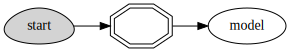

In [12]:
# Create a serving function object
serving = mlrun.new_function(name="serving", kind="serving", image="mlrun/mlrun")

# Add a model to the model serving function object
serving.add_model(key='model',model_path=train_run.outputs["model"], class_name='mlrun.frameworks.sklearn.SklearnModelServer')

# plot the serving graph
serving.spec.graph.plot(rankdir="LR")

In [13]:
# save the function definition into a .yaml file and register it in the project
serving.export(target=f"./{project.context}/src/serving.yaml")
project.set_function(func="./src/serving.yaml", name="serving")

> 2023-04-09 09:07:16,433 [info] function spec saved to path: ././/src/serving.yaml


#### Speciel Cases

When creating a project for CI/CD there are speciel cases you need to take in consider, see the list below:

1. When creating a serving function the function spec contain metadata of the function steps or the function models, becuase of it you need to create a function.yaml file by using the [export()](https://docs.mlrun.org/en/latest/api/mlrun.runtimes.html?highlight=export#mlrun.runtimes.BaseRuntime.export) method after you are creating the function object and then set the function with this yaml file, with this approach all the function spec will be saved for future deployments.

For Example:
````
<function object>.export('./model_training.yaml')
````

````
project.set_function(
    func="training.yaml",name='training',with_repo=True,kind='serving')
````
2. In addition to the first point if you want to change the defualt funciton spec values e.g resources, node-selector and more, and make this change constant you will need to create a yaml function and point use the yaml function in the set_fucntion method.
3. When set a nuclio function the function handler is a combination of the file_name::function_handler, for example:
```
project.set_function(name='nuclio',handler='multi:multi_3',kind='nuclio',image='mlrun/mlrun',with_repo=True)
```

In [14]:
serving_func = project.deploy_function(function='serving',models=[{'key':'model','model_path':train_run.outputs["model"], 'class_name':'mlrun.frameworks.sklearn.SklearnModelServer'}])

> 2023-04-09 09:07:16,460 [info] Starting remote function deploy
2023-04-09 09:07:16  (info) Deploying function
2023-04-09 09:07:16  (info) Building
2023-04-09 09:07:16  (info) Staging files and preparing base images
2023-04-09 09:07:16  (info) Building processor image
2023-04-09 09:08:16  (info) Build complete
2023-04-09 09:08:24  (info) Function deploy complete
> 2023-04-09 09:08:27,330 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-new-git-proj-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['new-git-proj-serving-new-git-proj.default-tenant.app.cust-cs-il-3-5-2.iguazio-cd2.com/']}


In [15]:
my_data = '''{"inputs":[[-0.60150011,  0.51150308,  0.25701239, -1.51777297, -1.82961288,
         0.22983693, -0.40761625,  0.82325082,  1.1779216 ,  1.08424275,
        -0.7031145 , -0.40608979, -0.36305977,  1.28075006,  0.94445967,
         1.19105828,  1.93498414,  0.69911167,  0.50759757,  0.91565635]]}'''

In [16]:
serving_func.function.invoke('/',my_data)

> 2023-04-09 09:08:27,410 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-new-git-proj-serving.default-tenant.svc.cluster.local:8080/'}


{'id': 'fbff4968-b084-42b4-a11b-a35bb9b7bd2f',
 'model_name': 'model',
 'outputs': [1]}

### Run and set MLRun workflow

After you develop your functions in our example we build 3 function (data_fetch, training and serving) we will want to create a workflow that run those function one by one, for more information about workflow you can check  - [link](https://docs.mlrun.org/en/stable/projects/build-run-workflows-pipelines.html).

First thing to do is create a workflow.py file, for example:
```
%%writefile pipelines/training_pipeline.py
from kfp import dsl
import mlrun

@dsl.pipeline(
    name="batch-pipeline-academy",
    description="Example of batch pipeline for Iguazio Academy"
)
def pipeline(label_column: str, test_size=0.2):
    
    # Ingest the data set
    ingest = mlrun.run_function(
        'get-data',
        handler='prep_data',
        params={'label_column': label_column},
        outputs=["iris_dataset"]
    )
    
    # Train a model   
    train = mlrun.run_function(
        "train-model",
        handler="train_model",
        inputs={"dataset": ingest.outputs["iris_dataset"]},
        params={
            "label_column": label_column,
            "test_size" : test_size
        },
        outputs=['model']
    )
    
    # Deploy the model as a serverless function
    deploy = mlrun.deploy_function(
        "deploy-model",
        models=[{"key": "model", "model_path": train.outputs["model"]}]
    )

```

**Set workflow**

To set workflow to the project you need to use [project.set_workflow](https://docs.mlrun.org/en/stable/api/mlrun.projects.html?highlight=set_workflow#mlrun.projects.MlrunProject.set_workflow) method, this method add or update a workflow, specify a name and the code path in the project.yaml file

In this example we added a workflow named main that point to a file located ./project-context/src/workflow.py

In [17]:
project.set_workflow('main','./src/workflow.py')

To run the workflow you can use [project.run](https://docs.mlrun.org/en/stable/api/mlrun.projects.html?highlight=run#mlrun.projects.MlrunProject.run) method, this method allow you to run a workflow or shceudle a workflow using kubeflow pipelines by specifing the workflow name or the workflow file path.
This workflow will run all the functinos you set in to the project

**Run workflow**

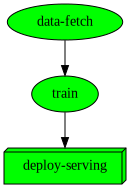

uid,start,state,name,parameters,results
...39c6c302,Apr 09 09:09:08,completed,train,,accuracy=0.9f1_score=0.875precision_score=0.875recall_score=0.875
...630f2e1b,Apr 09 09:08:38,completed,data-fetch,,


a668c9a7-27a2-446c-84fa-8e93fbd75ac7

In [18]:
# run workflow named main and wait for pipeline completion (watch=True)
project.run('main',watch=True)

**Run Schedule workflow**

For more inforation about scheduling workflows, please check this [link](https://docs.mlrun.org/en/latest/concepts/scheduled-jobs.html)

In [26]:
project.run('main',watch=True,schedule='0 * * * *')

> 2023-04-09 09:14:30,771 [warning] WARNING!, you seem to have uncommitted git changes, use .push()
> 2023-04-09 09:14:30,775 [info] executing workflow scheduling 'workflow-runner-main' remotely with kfp engine
> 2023-04-09 09:14:30,780 [info] Storing function: {'name': 'main', 'uid': 'c2fb535c8d87408aaad525096e1e5178', 'db': 'http://mlrun-api:8080'}
> 2023-04-09 09:14:31,181 [info] task schedule created: {'schedule': '0 * * * *', 'project': 'new-git-proj', 'name': 'main'}


### Set and register MLRun artifacts

For set artfiacts to the project you can use the [project.set_artifact](https://docs.mlrun.org/en/stable/api/mlrun.projects.html?highlight=set_artifact#mlrun.projects.MlrunProject.set_artifact) method, this method allows you to add/set an artifact in the project spec (will be registered on load).

In general you will want to use this method when you will want to register the artifact when you load the project for example:
* Develop a model artifact in development system and you want to use this model file in production
* Artifacts you want to register by defualt when you load or create a project

**Note -** To register artifact between difrrent environments e.g dev and prod you must upload your artifacts to a remote storage e.g s3

**Set a model artifact**

In [19]:
# get model obejct to register
model_obj = project.get_artifact('model')

In [20]:
# print model object yaml
print(model_obj.to_yaml())

kind: model
metadata:
  key: model
  project: new-git-proj
  iter: 0
  tree: a668c9a7-27a2-446c-84fa-8e93fbd75ac7
  hash: 2f7ea83911d06c0d7eccc34e3f5b7b817c6d6d2b
  tag: latest
  updated: '2023-04-09T09:09:12.875842+00:00'
  labels:
    workflow-id: a668c9a7-27a2-446c-84fa-8e93fbd75ac7
    framework: sklearn
spec:
  target_path: v3io:///projects/new-git-proj/artifacts/a668c9a7-27a2-446c-84fa-8e93fbd75ac7/train/0/model/
  size: 96208
  db_key: model
  extra_data:
    feature-importance: v3io:///projects/new-git-proj/artifacts/a668c9a7-27a2-446c-84fa-8e93fbd75ac7/train/0/feature-importance.html
    test_set: v3io:///projects/new-git-proj/artifacts/a668c9a7-27a2-446c-84fa-8e93fbd75ac7/train/0/test_set.parquet
    confusion-matrix: v3io:///projects/new-git-proj/artifacts/a668c9a7-27a2-446c-84fa-8e93fbd75ac7/train/0/confusion-matrix.html
    roc-curves: v3io:///projects/new-git-proj/artifacts/a668c9a7-27a2-446c-84fa-8e93fbd75ac7/train/0/roc-curves.html
    calibration-curve: v3io:///project

In [21]:
#print target path
print(model_obj.target_path)

v3io:///projects/new-git-proj/artifacts/a668c9a7-27a2-446c-84fa-8e93fbd75ac7/train/0/model/


In [22]:
#print model file
model_obj.model_file

'model.pkl'

In [23]:
# set model artifact to the project
project.set_artifact(key='model-test',artifact=mlrun.artifacts.ModelArtifact(model_file=model_obj.model_file),target_path=model_obj.target_path)

**Note -** by default the artifact type is equal to mlrun.artifacts.Artifact() for specifing difrrent types you need to forward the relvant artifact object (then you can specify specific paramtest to the artifcat object type), see below list:
```
    "dir": mlrun.artifacts.DirArtifact,
    "link": mlrun.artifacts.LinkArtifact,
    "plot": mlrun.artifacts.PlotArtifact,
    "chart": mlrun.artifacts.ChartArtifact,
    "table": mlrun.artifacts.TableArtifact,
    "model": mlrun.artifacts.ModelArtifact,
    "dataset": mlrun.artifacts.DatasetArtifact,
    "plotly": mlrun.artifacts.PlotlyArtifact,
    "bokeh": mlrun.artifacts.BokehArtifact,
```

**Spicial Cases -**
* When MLRun creating an artifact there are values that are proccesed in runtime e.g dataset preview or model metrics, those values are stored in the artifact spec, if you wish to store the artifact spec for registring the artifact with those values you will need to export the artifcat object and set the artifact.yaml file, see below example:

```
model_obj = project.get_artifact('model')
model_obj.export(./model_artifact.yaml)
project.set_artifact(key='model',artifact='./model_artifact.yaml')
```


### Create and save project YAML

The project YAML contains metadata about the project for example you can see that the project yaml contains all the function we set to the project, the artifact and the workflow, and then when you will load the project it will loaded with all those functions, artifact and workflow.

In general MLRun uses those metadata to create object for examples funciton obejects and then use those objects to run the functions.

In [24]:
print(project.to_yaml())

kind: project
metadata:
  name: new-git-proj
spec:
  functions:
  - url: ./src/data_fetch.py
    name: data-fetch
    kind: job
    image: mlrun/mlrun
    handler: data_fetch
    with_repo: true
  - url: ./src/train.py
    name: train
    kind: job
    image: mlrun/mlrun
    handler: train
    with_repo: true
  - url: ./src/serving.yaml
    name: serving
  workflows:
  - path: ./src/workflow.py
    name: main
  artifacts:
  - kind: model
    metadata:
      project: new-git-proj
      key: model-test
    spec:
      target_path: v3io:///projects/new-git-proj/artifacts/a668c9a7-27a2-446c-84fa-8e93fbd75ac7/train/0/model/
      model_file: model.pkl
    status:
      state: created
  conda: ''
  source: git://github.com/GiladShapira94/example-ci-cd.git#master
  origin_url: git://github.com/GiladShapira94/example-ci-cd.git#refs/heads/master
  load_source_on_run: true
  desired_state: online



To export the project content to yaml file and save project in database the [save](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=save#mlrun.projects.MlrunProject.save) method.

In [25]:
project.save()

### Push and Manage your git repo or archive file

**Create a git remote**

If you do not clone any files and you do not have any git remotes configured you can use [project.create_remote](https://docs.mlrun.org/en/stable/api/mlrun.projects.html?highlight=create_remote#mlrun.projects.MlrunProject.create_remote) this method creates git remote and add the remote to the project as the project source.

for exmaple:
```
project.create_remote(url='https://github.com/mlrun/example-ci-cd.git',name='mlrun-remote',branch='master')
```

**Push changes to git repo**

After you made changes in your code you will want to push your project context to GitHub repo, for this you can use [project.push](https://docs.mlrun.org/en/stable/api/mlrun.projects.html?highlight=push#mlrun.projects.MlrunProject.push)
```
project.push(branch='master',message='update',add=['project.yaml','./src/data_fetch.py','./src/serving.yaml','./src/train.py','./src/workflow.py'])
```

### Done! 
**Now you have a project YAML for CI/CD Automation  - Later we will demostrate how to load a project and use this Project YAML**